# Unscented Kalman filter (UKF)

Some problems of the extended Kalman filter:

* linearization: considers only first-order Taylor term in the expansion
* it is tedious to calculate the Jacobian matrix
* filter parameters are difficult to adjust, sometimes filter estimates a diverging system state

Experience tells the unscented Kalman filter (**UKF**) is as good or even better.

<img src="img/Uhlmann.jpg" style="float:right;" width="100" />

Where did this bizarre name come from? Its inventor, Jeffrey Uhlmann tells us:

"What's with the Name „Unscented”? „Initially I only referred to it as the "new filter". Needing a more specific name, people in my lab began referring to it as the "Uhlmann filter", which obviously isn't a name that I could use, so I had to come up with an official name. One evening everyone else in the lab was at the Royal Opera House, and as I was working I noticed someone's deodorant on a desk. The word "unscented" caught my eye as the perfect technical term. At first people in the lab thought it was absurd - which is okay because absurdity is my guiding principle” [Jeffrey Uhlmann](http://ethw.org/First-Hand:The_Unscented_Transform )

## The main idea of UKF

Kalman filtering makes propagation of system state with a Gaussian pdf and measurement update through a linear transform. As it is more easy to approximate a Gaussian pdf, or more generally an arbitrary pdf than a nonlinear transform, therefore we keep nonlinear transform and approximate parameters (expectation and covariance) of the Gaussian pdf by using a set of discrete points (**sigma points**). This is the essence of **unscented transform** (and unscented Kalman filter):

1. choose sigma points to characterize exactly mean and covariance of system state
2. transform sigma points by nonlinear transforms $f$, $h$ into system and measurement space
3. approximate mean and covariance of system state from transformed sigma points

<img src="img/UKF_idea.png" width="450">

This procedure is a relative of *Monte-Carlo* methods. Only discrete points are chosen deterministically instead of randomly.

### Sigma points

<img src="img/sigma.png" width="450">
<div style="text-align:center;font-size:8px;">source: Roger R Labbe: [Kalman and Bayesian Filters in Python](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python)</div>

$2n + 1$ **<span style="color:blue;">sigma points</span>** $\mathbf{X}_i$  are selected in an $n$-dimensional state space

transformed sigma points have weights $W_i$


### Van der Merwe scaled sigma points 

Set of sigma points are described by the following formulas:

$$ \mathbf{X_{0}}=\mathbf{\mu }$$

$$ \mathbf{X_{i}}=\mathbf{\mu }+\left [\sqrt{\left (n+\lambda \right )\mathbf{P}}\right ]_{i}\qquad i=1,...,n$$

$$ \mathbf{X_{i}}=\mathbf{\mu }- \left [\sqrt{\left (n+\lambda \right )\mathbf{P}}\right ]_{i-n}\qquad i=n+1,...,2n$$

where $\left [\mathbf{A}\right ]_{i}$ denotes $i$th column (or row) of the symmetric matrix $\mathbf{A}$ and 

$$\lambda =\alpha ^{2}\left (n+k\right )- n,\qquad k=3- n.$$

$\lambda$ is a scale factor, the parameter $\alpha$ determines distance of sigma points from the point $\mathbf{\mu }$ and $k$ is another scale factor.

<img src="img/merwe.png" width="350">
<div style="text-align:center;font-size:8px;">source: Roger R Labbe: [Kalman and Bayesian Filters in Python](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python)</div>

As we see, calculation of sigma points requires the *square root* of the system state (positive definite and symmetrix) covariance matrix $\mathbf{P}$. Since it is symmetric, it is advantageous to use Cholesky factorization of the matrix, $\mathbf{P} = \mathbf{L}\mathbf{L}^T$. Lower triangular matrix $\mathbf{L}$ is a kind of "square root" of matrix $\mathbf{P}$.




### Van der Merwe weights

$$W_{0}^{m}=\frac{\lambda }{n+\lambda }$$

$$W_{0}^{c}=\frac{\lambda }{n+\lambda }+1- \alpha ^{2}+\beta$$

$$W_{i}^{m} = W_{i}^{c}=\frac{1 }{2(n+\lambda)}, \qquad i=1,...,2n$$

For Gaussian pdfs it is best to use the following parameters:

$\beta=2$, $k=3-n$, $0\le \alpha \le 1$.

### Unscented transform

In unscented transform sigma vectors are transformed nonlinearly with function $g$ 

$$\mathbf{Y}_i = g(\mathbf{X}_i)\qquad i=0,...,2n$$

and weighted average of transformed points yield approximate posterior mean and covariance:

$$\overline{\mathbf{Y}} \approx \sum_{i=0}^{2n} W_i^{m}\mathbf{Y}_i$$

$$\mathbf{P}_{\mathbf{Y}} \approx \sum_{i=0}^{2n} W_i^{c}(\mathbf{Y}_i-\overline{\mathbf{Y}})(\mathbf{Y}_i-\overline{\mathbf{Y}})^T.$$

### UKF filter equations

Best system state estimate is determined in two steps similarly to the Kalman filter. When initial system state and state covariance are known and sigma points are available, the algorithm makes a step from epoch $k-1$ to epoch $k$ according to the following equiations:

**State transition**

transform of sigma points

$$\mathbf{X}_{i,t}=\mathbf{f}\left (\mathbf{X}_{i,k- 1},\mathbf{u}_{k- 1}\right )\qquad i=0,...,2n$$

state estimation before measurement update

$$ \hat{\mathbf{x}}_{k}^{- }=\sum _{i=0}^{2n}W_{i}^{m}\mathbf{X}_{i,t}$$

estimation of state covariance matrix

$$\hat{\mathbf{P}}_{k}^{- }=\sum _{j=0}^{2n}W_{j}^{c}\left (\mathbf{X}_{j,t}- \hat{\mathbf{x}}_{k}^{- }\right )\left (\mathbf{X}_{j,t}- \hat{\mathbf{x}}_{k}^{- }\right )^{T}+\mathbf{Q}_{k- 1}$$

Please note that estimation of state and state covariance before measurement update are performed though "transfer" of sigma points with function $\mathbf{f}$ (state transition function).

**Estimation of state after measurement update**

transform of sigma points into measurement space

$$ \mathbf{z}_{i,t}=\mathbf{h}\left (\mathbf{X}_{i,k- 1},\mathbf{v}_{k- 1}\right )\qquad i=0,...,2n$$

estimation with sigma points

$$\hat{\mathbf{z}}_{k}=\sum _{i=0}^{2n}W_{i}^{m}\mathbf{z}_{i,t}$$

estimation of system state covariance and cross-covariance matrices

$$ \mathbf{P}_{z}=\sum _{j=0}^{2n}W_{j}^{c}\left (\mathbf{z}_{j,t}- \hat{\mathbf{z}}_{k}\right )\left (\mathbf{z}_{j,t}- \hat{\mathbf{z}}_{k}\right )^{T}+\mathbf{R}_{k- 1}$$

$$ \mathbf{P}_{x,z}=\sum _{j=0}^{2n}W_{j}^{c}\left (\mathbf{X}_{j,t}- \hat{\mathbf{x}}_{k}^{- }\right )\left (\mathbf{z}_{j,t}- \hat{\mathbf{z}}_{k}\right )^{T}$$

update Kalman gain matrix

$$ \mathbf{K}_{k}=\mathbf{P}_{x,z}\mathbf{P}_{z}^{- 1}$$

estimation of system state and covariance after measurement update

$$\hat{\mathbf{x}}_{k}=\hat{\mathbf{x}}_{k}^{- }+\mathbf{K}_{k}\left (\mathbf{z}_{k}- \hat{\mathbf{z}}_{k}\right )$$

$$ \mathbf{P}_{k}=\hat{\mathbf{P}}_{k}^{- }- \mathbf{K}_{k}\mathbf{P}_{z}\mathbf{K}_{k}^{T}$$

Here we see that estimation of state, state covariance and cross-covariance after measurement update are performed though "transfer" of sigma points with function $\mathbf{h}$ (measurement function).

Number of operations of the UKF and EKF filtering algorithms are similar, but the principal advantage of UKF is that it does not require calculation of the Jacobian of state transition and measurmenet functions.

## Wheel odometry with unscented Kalman filtering

We have already processed acceleration data in the Gersdorf and Freese paper with extended Kalman filter. Now we make the same with the unscented Kalman filter. For this the UKF implementation of Roger R. Labbe's [`FilterPy`](https://github.com/rlabbe/filterpy) library is used. All the necessary functions are collected in module `UKF.py`, other functions of `FilterPy` are found on Roger R. Labbe's [GitHub](https://github.com/rlabbe/filterpy) pages.

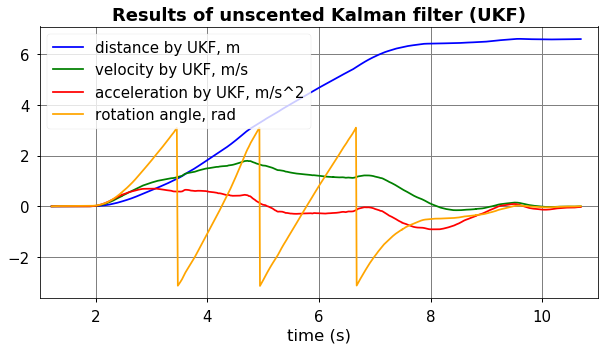

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from UKF import MerweScaledSigmaPoints as SP
from UKF import UnscentedKalmanFilter as UKF 


# unscented Kalman filter (UKF)

def f(x,dt):
    """ state propagation function
     x  = state vector (p,pdot,pdotdot)
     dt = time difference
    """
    f1 = x[0] + x[1]*dt + 0.5*x[2]*dt**2
    f2 = x[1] + x[2]*dt
    f3 = x[2]
    return np.array([f1,f2,f3]).flatten()


def h(x,rs=0.095,rw=0.35):
    ## measurement function
    ## x  = state vector (p,pdot,pdotdot)
    ## rs = sensor offset from wheel axis
    ## rw = wheel radius
    g = 9.81
    h1 = -g*np.sin(x[0]/rw) + x[2]*np.cos(x[0]/rw) - x[2]*rs/rw
    h2 = -g*np.cos(x[0]/rw) - x[2]*np.sin(x[0]/rw) - (x[1])**2*rs/(rw**2)
    return np.array([h1,h2]).flatten()

"""
Unscented Kalman filter (UKF) for odometry with dual-axis accelerometer
 t - vector of measurement epochs
 a1, a2 - measured centripetal and centrifugal accelerations (m/s**2)
 q - process noise variance (m/s**2)
 r - measurement noise variance (m/s**2)
"""

# data of wheel mounted Samsung Galaxy S2 accelerometer sensor
data = np.loadtxt("dat/a.txt")
t = data[:,0]
a1= data[:,1]
a2= data[:,2]

# variable for storing results
nt = t.shape[0]
# nt = 790

# time, state vector, rotation angle: t, p,vel,acc,theta
xe = np.zeros((nt,5))

# calculation of sigma points
spts = SP(n=3,alpha=0.1,beta=2.0,kappa=0)
#print(spts.weights())

# instantiate UKF filter
ukf = UKF(dim_x=3, dim_z=2, fx=f, hx=h, dt=0.012, points=spts)

q  = 0.07   # process noise
r  = 5.0    # measurement noise

Wk = np.array([0, 0, 1])
ukf.P = np.diag([0.01, 0.01, 0.01])
ukf.R = r**2*np.eye(2)
ukf.Q = q**2*np.outer(Wk,Wk)

xe[:,0]=t  # epochs
rw=0.35    # wheel radius

for i in range(1,nt):
    dt = t[i]-t[i-1]
    ukf.predict(dt)
    z = np.array([a1[i],a2[i]])
    ukf.update(z)
    xe[i,1:4] = ukf.x
    om = xe[i,1]/rw  # wheel rotation angle
    xe[i,4]=np.arctan2(np.sin(om),np.cos(om));  # angle: (-pi, pi)


## plot results
plt.figure(figsize=(10,5))
plt.plot(xe[:,0],xe[:,1], 'b-', label='distance by UKF, m')
plt.plot(xe[:,0],xe[:,2], 'g-', label='velocity by UKF, m/s')
plt.plot(xe[:,0],xe[:,3], 'r-', label='acceleration by UKF, m/s^2')
plt.plot(xe[:,0],xe[:,4], color='orange', label='rotation angle, rad')
plt.xlim(1,11)
plt.grid(color='grey')


plt.title(u'Results of unscented Kalman filter (UKF)', fontweight='bold')
plt.xlabel(u'time (s)')
#plt.ylabel('distance (m), acceleration (m/s^2)')
#plt.ylabel('velocity (m/s), angle (rad)')
 
plt.legend(loc='upper left', shadow=False)
plt.show()

### Odometry with data by Ákos Vinkó

Unscented Kalman filtering, similarly to extended Kalman filtering, was made with freewheel accelerometer data from a sensor mounted on a bycicle wheel. We thank [Ákos Vinkó](https://epito.bme.hu/vinko-akos) (Department of Highway and Railway Engineering) for providing these data.

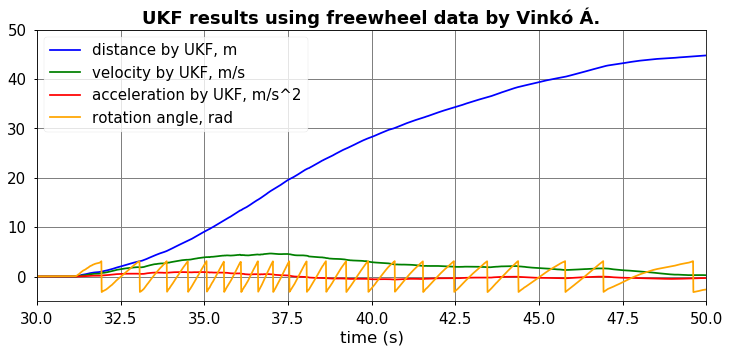

In [3]:
def h(x,rs=0.165,rw=0.33):
    ## measurement equation function
    ## x  = state vector (p,pdot,pdotdot)
    ## rs = sensor - wheel axis offset
    ## rw = wheel radius
    g = 9.81
    h1 = -g*np.sin(x[0]/rw) + x[2]*np.cos(x[0]/rw) - x[2]*rs/rw
    h2 = -g*np.cos(x[0]/rw) - x[2]*np.sin(x[0]/rw) - (x[1])**2*rs/(rw**2)
    return np.array([h1,h2]).flatten()


# GCDC accelerometer data of a wheel mounted sensor (from Ákos Vinkó)
data = np.loadtxt("dat/asz.dat")
# section after 30 sec is interesting for us
skip = 96
t = data[skip:,0]
a1= data[skip:,1]
a2= -data[skip:,2]

# variable for storing results
nt = t.shape[0]

rw=0.33    # radius of wheel

# time, state vector, rotation angle: t, p,vel,acc,theta
xe = np.zeros((nt,5))
# sensor starts in upward position, angle pi
#dist = np.pi*rw
#xe[0,1] = dist
#xe[0,4] = np.pi

# calculation of sigma points
spts = SP(n=3,alpha=0.1,beta=2.0,kappa=0)
#print(spts.weights())

# create UKF filter instance
ukf = UKF(dim_x=3, dim_z=2, fx=f, hx=h, dt=0.012, points=spts)

q  = 0.01   # process noise
r  = 10.0    # measurement noise

Wk = np.array([0, 0, 1])
ukf.P = np.diag([0.01, 0.01, 0.01])
ukf.R = r**2*np.eye(2)
ukf.Q = q**2*np.outer(Wk,Wk)

xe[:,0]=t  # epochs


for i in range(1,nt):
    dt = t[i]-t[i-1]
    ukf.predict(dt)
    z = np.array([a1[i],a2[i]])
    ukf.update(z)
    xe[i,1:4] = ukf.x
    om = xe[i,1]/rw  # wheel rotation angle
    xe[i,4]=np.arctan2(np.sin(om),np.cos(om));  # angle: (-pi, pi)


## plot results
plt.figure(figsize=(12,5))
plt.plot(xe[:,0],xe[:,1], 'b-', label='distance by UKF, m')
plt.plot(xe[:,0],xe[:,2], 'g-', label='velocity by UKF, m/s')
plt.plot(xe[:,0],xe[:,3], 'r-', label='acceleration by UKF, m/s^2')
plt.plot(xe[:,0],xe[:,4], color='orange', label='rotation angle, rad')
plt.xlim(30,50)
plt.ylim(-5,50)
plt.grid(color='grey')

plt.title('UKF results using freewheel data by Vinkó Á.', fontweight='bold')
plt.xlabel(u'time (s)')
#plt.ylabel('distance (m), acceleration (m/s^2)')
#plt.ylabel('velocity (m/s), angle (rad)')
 
plt.legend(loc='upper left', shadow=False) 
plt.show()


Obviously, a comparison of UKF and EKF filtering should be made, but this task is left to the reader.